In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! git clone https://github.com/amirgholami/adahessian.git #original, if we want to modify something need to replace with a forked one

fatal: destination path 'adahessian' already exists and is not an empty directory.


In [3]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/Opti-ML') #to access other files
sys.path.insert(0,"adahessian/image_classification/")
#import os
#assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [4]:
# Useful starting lines
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms, utils
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import copy
#import torch_xla
#import torch_xla.core.xla_model as xm

from optimizer_lessold import set_parameter_requires_grad, initialize_model, train_and_test, test_model
from optim_adahessian import Adahessian

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Main function

In [5]:
def run(num_epoch = 100, is_renormalized=True, make_small=False):

  print(f"### Starting run ### \n   with num_epoch={num_epoch}, is_renormalized={is_renormalized}, make_small={make_small}")

  if is_renormalized:
    std = [0.0001,1,10000]
  else:
    std = [1,1,1]
  print(f"std = {std} ")
  renormalize = transforms.Normalize([0,0,0], std, inplace=False)
  transform =  transforms.Compose([ToTensor(),renormalize])
  train_data=datasets.CIFAR10(root='data',train=True,download=True,transform=transform)
  test_data=datasets.CIFAR10(root='data',train=False,download=True,transform=transform)



  # Use a small subset of the data
  # only error: 'Subset' object has no attribute 'targets'
  if make_small: # put False if don't want it
    rng = np.random.default_rng()

    indices = rng.choice(len(train_data), 1000, replace=False)
    train_data = torch.utils.data.Subset(train_data, indices)

    indices = rng.choice(len(test_data), 200, replace=False)
    test_data = torch.utils.data.Subset(test_data, indices)
    labels = np.array([0,1,2,3,4,5,6,7,8,9])
  else:
      labels=np.unique(np.array(train_data.targets)) #don't seem to work for all datasets, like 'Subset' objects
  print("labels=", labels)



  batch_size = 256
  trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True) #change batch size with our need
  testloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
  classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



  device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
  )
  print(f"Using {device} device")

  #device = xm.xla_device()



  req_grad = True
  seed = 100
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  # Initialize the model for this run
  model, input_size = initialize_model(use_pretrained=False)



  # Send the model to GPU

  model = model.to(device)

  # Gather the parameters to be optimized/updated in this run. If we are
  #  finetuning we will be updating all parameters. However, if we are
  #  doing feature extract method, we will only update the parameters
  #  that we have just initialized, i.e. the parameters with requires_grad
  #  is True.
  params_to_update = model.parameters()
  #print("Params to learn:")
  if req_grad:
      params_to_update = []
      for name,param in model.named_parameters():
          if param.requires_grad == True:
              params_to_update.append(param)
              #print("\t",name)
  else:
      for name,param in model.named_parameters():
          if param.requires_grad == True:
              #print("\t",name)
              pass


  lr=0.15 # default: 0.15
  betas = (0.9, 0.999) # default: (0.9, 0.999)
  weight_decay = 0.0005 # default: 0
  hessian_power = 1 # default: 1
  momentum = 0.95 # 0.95

  #optimizer_name = 'adahessian'
  optimizer_name = 'adahessian' # 'adahessian' only

  print(f"Parameters of {optimizer_name}: \n    lr={lr}, betas={betas}, weight_decay={weight_decay}, hessian_power={hessian_power}")


  if optimizer_name == 'adahessian':
    optimizer = Adahessian(params_to_update, lr=lr, betas=betas, weight_decay=weight_decay,hessian_power=hessian_power) #set the parameter
  elif optimizer_name == 'SGD':
    optimizer = optim.SGD(params_to_update, lr=lr, momentum=momentum, weight_decay=weight_decay)
  elif optimizer_name == "adam":
    optimizer = optim.Adam(params_to_update, lr=lr, weight_decay=weight_decay)
  criterion = nn.CrossEntropyLoss()

  scheduler_name = "multilr"
  scheduler = None
  if scheduler_name == "multilr":
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[80, 120], gamma=0.1)
  if is_renormalized:
    case_name = "renormalized"
  else:
    case_name = "unrenormalized"
  path= f'./drive/MyDrive/Opti-ML/model_weights/{case_name}_model_{optimizer_name}.pt'
  train_loss_path = f'./drive/MyDrive/Opti-ML/loss_and_acc/{case_name}_train_loss_{optimizer_name}.txt'
  train_acc_path = f'./drive/MyDrive/Opti-ML/loss_and_acc/{case_name}_train_acc_{optimizer_name}.txt'
  test_loss_path = f'./drive/MyDrive/Opti-ML/loss_and_acc/{case_name}_test_loss_{optimizer_name}.txt'
  test_acc_path = f'./drive/MyDrive/Opti-ML/loss_and_acc/{case_name}_test_acc_{optimizer_name}.txt'



  #check the warning, nothing more on the adahessian git
  # model,traindataset,batch_size,kfold,criterion,optimizer_name,scheduler,num_epoch,savepath,use_pretrained,lr,betas,momentum,weight_decay,hessian_power,device='cpu'
  train_loss, list_testloss, lowest_loss, model_weights, train_acc, test_acc = train_and_test(model,trainloader,testloader,criterion,optimizer,scheduler,num_epoch,path,device)
  with open(train_loss_path, 'w') as fp:
      for item in train_loss:
          # write each item on a new line
          fp.write("%s\n" % item)
  with open(train_acc_path, 'w') as fp:
      for item in train_acc:
          # write each item on a new line
          fp.write("%s\n" % item)
  with open(test_loss_path, 'w') as fp:
      for item in list_testloss:
          # write each item on a new line
          fp.write("%s\n" % item)
  with open(test_acc_path, 'w') as fp:
      for item in test_acc:
          # write each item on a new line
          fp.write("%s\n" % item)

  testloader = DataLoader(test_data, batch_size=1, shuffle=True)
  accuracy = test_model(model,testloader,path,device)
  print(f"Accuracy={accuracy}")

  if is_renormalized:
    word = "not"
  else:
    word = " "

  plt.plot(train_loss,'.-')
  plt.plot(list_testloss,'.-')
  plt.title(f"Evolution of loss during training,{word} normalized")
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.legend(["train","test"])
  plt.savefig(f"drive/MyDrive/Opti-ML/graphics/{case_name}_{optimizer_name}_loss.pdf")

# Runs

In [6]:
num_epoch=100

### Starting run ### 
   with num_epoch=100, is_renormalized=True, make_small=False
std = [0.0001, 1, 10000] 
Files already downloaded and verified
Files already downloaded and verified
labels= [0 1 2 3 4 5 6 7 8 9]
Using cuda device


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Parameters of adahessian: 
    lr=0.15, betas=(0.9, 0.999), weight_decay=0.0005, hessian_power=1


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0/99
----------


/usr/local/lib/python3.10/dist-packages/torch/autograd/__init__.py:200: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ../torch/csrc/autograd/engine.cpp:1151.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Train Loss: 1.6607
Test Loss: 2.1332


  1%|          | 1/100 [01:18<2:09:01, 78.20s/it]

Train accuracy: 0.3548
Test accuracy: 0.3374
Epoch 1/99
----------
Train Loss: 1.1875
Test Loss: 1.9347


  2%|▏         | 2/100 [02:27<1:58:42, 72.68s/it]

Train accuracy: 0.4363
Test accuracy: 0.4179
Epoch 2/99
----------
Train Loss: 0.9650
Test Loss: 1.2911


  3%|▎         | 3/100 [03:36<1:55:02, 71.16s/it]

Train accuracy: 0.6128
Test accuracy: 0.5644
Epoch 3/99
----------
Train Loss: 0.8369
Test Loss: 1.1951


  4%|▍         | 4/100 [04:45<1:52:38, 70.41s/it]

Train accuracy: 0.6639
Test accuracy: 0.5935
Epoch 4/99
----------
Train Loss: 0.7233
Test Loss: 1.1583


  5%|▌         | 5/100 [05:55<1:51:19, 70.31s/it]

Train accuracy: 0.7174
Test accuracy: 0.6262
Epoch 5/99
----------
Train Loss: 0.6337
Test Loss: 1.4001


  6%|▌         | 6/100 [07:06<1:50:24, 70.47s/it]

Train accuracy: 0.6761
Test accuracy: 0.5828
Epoch 6/99
----------
Train Loss: 0.5590
Test Loss: 1.3095


  7%|▋         | 7/100 [08:16<1:49:09, 70.42s/it]

Train accuracy: 0.7221
Test accuracy: 0.6115
Epoch 7/99
----------
Train Loss: 0.4688
Test Loss: 1.1354


  8%|▊         | 8/100 [09:27<1:48:14, 70.59s/it]

Train accuracy: 0.7937
Test accuracy: 0.6536
Epoch 8/99
----------
Train Loss: 0.4024
Test Loss: 1.1352


  9%|▉         | 9/100 [10:38<1:46:59, 70.55s/it]

Train accuracy: 0.8558
Test accuracy: 0.6603
Epoch 9/99
----------
Train Loss: 0.3261
Test Loss: 1.2942


 10%|█         | 10/100 [11:49<1:45:56, 70.63s/it]

Train accuracy: 0.8449
Test accuracy: 0.6537
Epoch 10/99
----------
Train Loss: 0.2745
Test Loss: 1.9081


 11%|█         | 11/100 [13:00<1:45:04, 70.84s/it]

Train accuracy: 0.7286
Test accuracy: 0.5847
Epoch 11/99
----------
Train Loss: 0.2302
Test Loss: 1.2352


 12%|█▏        | 12/100 [14:10<1:43:44, 70.73s/it]

Train accuracy: 0.9208
Test accuracy: 0.6865
Epoch 12/99
----------
Train Loss: 0.1806
Test Loss: 1.3833


 13%|█▎        | 13/100 [15:21<1:42:20, 70.58s/it]

Train accuracy: 0.8899
Test accuracy: 0.6619
Epoch 13/99
----------
Train Loss: 0.1571
Test Loss: 1.4350


 14%|█▍        | 14/100 [16:31<1:41:16, 70.66s/it]

Train accuracy: 0.9288
Test accuracy: 0.6810
Epoch 14/99
----------
Train Loss: 0.1343
Test Loss: 2.1263


 15%|█▌        | 15/100 [17:41<1:39:36, 70.31s/it]

Train accuracy: 0.7918
Test accuracy: 0.6050
Epoch 15/99
----------
Train Loss: 0.1100
Test Loss: 1.4601


 16%|█▌        | 16/100 [18:51<1:38:21, 70.26s/it]

Train accuracy: 0.9479
Test accuracy: 0.6951
Epoch 16/99
----------
Train Loss: 0.0995
Test Loss: 1.5849


 17%|█▋        | 17/100 [20:01<1:37:10, 70.25s/it]

Train accuracy: 0.9465
Test accuracy: 0.6904
Epoch 17/99
----------
Train Loss: 0.0834
Test Loss: 1.4886


 18%|█▊        | 18/100 [21:11<1:35:52, 70.16s/it]

Train accuracy: 0.9628
Test accuracy: 0.6980
Epoch 18/99
----------
Train Loss: 0.0854
Test Loss: 1.5111


 19%|█▉        | 19/100 [22:22<1:34:56, 70.33s/it]

Train accuracy: 0.9493
Test accuracy: 0.6881
Epoch 19/99
----------
Train Loss: 0.0740
Test Loss: 1.5134


 20%|██        | 20/100 [23:32<1:33:45, 70.32s/it]

Train accuracy: 0.9519
Test accuracy: 0.6921
Epoch 20/99
----------
Train Loss: 0.0599
Test Loss: 1.6416


 21%|██        | 21/100 [24:42<1:32:31, 70.27s/it]

Train accuracy: 0.9553
Test accuracy: 0.6899
Epoch 21/99
----------
Train Loss: 0.0632
Test Loss: 1.8450


 22%|██▏       | 22/100 [25:53<1:31:33, 70.43s/it]

Train accuracy: 0.9109
Test accuracy: 0.6607
Epoch 22/99
----------
Train Loss: 0.0635
Test Loss: 1.9271


 23%|██▎       | 23/100 [27:04<1:30:25, 70.46s/it]

Train accuracy: 0.8911
Test accuracy: 0.6498
Epoch 23/99
----------
Train Loss: 0.0651
Test Loss: 1.6328


 24%|██▍       | 24/100 [28:14<1:29:11, 70.42s/it]

Train accuracy: 0.9575
Test accuracy: 0.6928
Epoch 24/99
----------
Train Loss: 0.0700
Test Loss: 1.5556


 25%|██▌       | 25/100 [29:24<1:27:56, 70.35s/it]

Train accuracy: 0.9609
Test accuracy: 0.6933
Epoch 25/99
----------
Train Loss: 0.0603
Test Loss: 1.5492


 26%|██▌       | 26/100 [30:34<1:26:20, 70.01s/it]

Train accuracy: 0.9787
Test accuracy: 0.7051
Epoch 26/99
----------
Train Loss: 0.0551
Test Loss: 1.7931


 27%|██▋       | 27/100 [31:43<1:25:03, 69.91s/it]

Train accuracy: 0.9377
Test accuracy: 0.6755
Epoch 27/99
----------
Train Loss: 0.0550
Test Loss: 1.6541


 28%|██▊       | 28/100 [32:52<1:23:38, 69.70s/it]

Train accuracy: 0.9609
Test accuracy: 0.6960
Epoch 28/99
----------
Train Loss: 0.0482
Test Loss: 1.6979


 29%|██▉       | 29/100 [34:03<1:22:50, 70.01s/it]

Train accuracy: 0.9659
Test accuracy: 0.6930
Epoch 29/99
----------
Train Loss: 0.0617
Test Loss: 1.4890


 30%|███       | 30/100 [35:14<1:22:02, 70.32s/it]

Train accuracy: 0.9830
Test accuracy: 0.7076
Epoch 30/99
----------
Train Loss: 0.0517
Test Loss: 1.5762


 31%|███       | 31/100 [36:24<1:20:40, 70.16s/it]

Train accuracy: 0.9764
Test accuracy: 0.6997
Epoch 31/99
----------
Train Loss: 0.0526
Test Loss: 1.5808


 32%|███▏      | 32/100 [37:33<1:19:12, 69.89s/it]

Train accuracy: 0.9707
Test accuracy: 0.7007
Epoch 32/99
----------
Train Loss: 0.0581
Test Loss: 1.5333


 33%|███▎      | 33/100 [38:43<1:17:58, 69.83s/it]

Train accuracy: 0.9779
Test accuracy: 0.7090
Epoch 33/99
----------
Train Loss: 0.0526
Test Loss: 1.7456


 34%|███▍      | 34/100 [39:53<1:16:50, 69.85s/it]

Train accuracy: 0.9455
Test accuracy: 0.6837
Epoch 34/99
----------
Train Loss: 0.0525
Test Loss: 1.6257


 35%|███▌      | 35/100 [41:02<1:15:36, 69.79s/it]

Train accuracy: 0.9733
Test accuracy: 0.6914
Epoch 35/99
----------
Train Loss: 0.0545
Test Loss: 2.1337


 36%|███▌      | 36/100 [42:13<1:14:39, 69.99s/it]

Train accuracy: 0.8655
Test accuracy: 0.6321
Epoch 36/99
----------
Train Loss: 0.0618
Test Loss: 1.5899


 37%|███▋      | 37/100 [43:23<1:13:36, 70.10s/it]

Train accuracy: 0.9760
Test accuracy: 0.7040
Epoch 37/99
----------
Train Loss: 0.0465
Test Loss: 1.5346


 38%|███▊      | 38/100 [44:34<1:12:29, 70.15s/it]

Train accuracy: 0.9837
Test accuracy: 0.7143
Epoch 38/99
----------
Train Loss: 0.0543
Test Loss: 1.9036


 39%|███▉      | 39/100 [45:44<1:11:16, 70.11s/it]

Train accuracy: 0.9212
Test accuracy: 0.6633
Epoch 39/99
----------
Train Loss: 0.0449
Test Loss: 1.5573


 40%|████      | 40/100 [46:55<1:10:22, 70.38s/it]

Train accuracy: 0.9875
Test accuracy: 0.7100
Epoch 40/99
----------
Train Loss: 0.0505
Test Loss: 1.8396


 41%|████      | 41/100 [48:06<1:09:37, 70.81s/it]

Train accuracy: 0.9209
Test accuracy: 0.6770
Epoch 41/99
----------
Train Loss: 0.0519
Test Loss: 1.6450


 42%|████▏     | 42/100 [49:17<1:08:16, 70.63s/it]

Train accuracy: 0.9742
Test accuracy: 0.7022
Epoch 42/99
----------
Train Loss: 0.0429
Test Loss: 1.7805


 43%|████▎     | 43/100 [50:27<1:06:59, 70.51s/it]

Train accuracy: 0.9455
Test accuracy: 0.6739
Epoch 43/99
----------
Train Loss: 0.0657
Test Loss: 1.6138


 44%|████▍     | 44/100 [51:37<1:05:45, 70.46s/it]

Train accuracy: 0.9705
Test accuracy: 0.6995
Epoch 44/99
----------
Train Loss: 0.0457
Test Loss: 1.7131


 45%|████▌     | 45/100 [52:48<1:04:43, 70.62s/it]

Train accuracy: 0.9630
Test accuracy: 0.6890
Epoch 45/99
----------
Train Loss: 0.0576
Test Loss: 1.6646


 46%|████▌     | 46/100 [53:59<1:03:41, 70.76s/it]

Train accuracy: 0.9564
Test accuracy: 0.6938
Epoch 46/99
----------
Train Loss: 0.0385
Test Loss: 1.5736


 47%|████▋     | 47/100 [55:11<1:02:44, 71.03s/it]

Train accuracy: 0.9864
Test accuracy: 0.7090
Epoch 47/99
----------
Train Loss: 0.0459
Test Loss: 1.6721


 48%|████▊     | 48/100 [56:22<1:01:30, 70.97s/it]

Train accuracy: 0.9729
Test accuracy: 0.7016
Epoch 48/99
----------
Train Loss: 0.0648
Test Loss: 1.6098


 49%|████▉     | 49/100 [57:32<1:00:05, 70.70s/it]

Train accuracy: 0.9573
Test accuracy: 0.6908
Epoch 49/99
----------
Train Loss: 0.0536
Test Loss: 1.5538


 50%|█████     | 50/100 [58:43<58:57, 70.75s/it]  

Train accuracy: 0.9717
Test accuracy: 0.6986
Epoch 50/99
----------
Train Loss: 0.0372
Test Loss: 1.6365


 51%|█████     | 51/100 [59:54<57:52, 70.86s/it]

Train accuracy: 0.9760
Test accuracy: 0.7030
Epoch 51/99
----------
Train Loss: 0.0424
Test Loss: 1.7395


 52%|█████▏    | 52/100 [1:01:05<56:51, 71.08s/it]

Train accuracy: 0.9585
Test accuracy: 0.6834
Epoch 52/99
----------
Train Loss: 0.0568
Test Loss: 1.7288


 53%|█████▎    | 53/100 [1:02:16<55:40, 71.08s/it]

Train accuracy: 0.9382
Test accuracy: 0.6784
Epoch 53/99
----------
Train Loss: 0.0480
Test Loss: 1.7143


 54%|█████▍    | 54/100 [1:03:28<54:39, 71.30s/it]

Train accuracy: 0.9492
Test accuracy: 0.6824
Epoch 54/99
----------
Train Loss: 0.0477
Test Loss: 1.6293


 55%|█████▌    | 55/100 [1:04:40<53:32, 71.38s/it]

Train accuracy: 0.9719
Test accuracy: 0.7047
Epoch 55/99
----------
Train Loss: 0.0510
Test Loss: 2.0150


 56%|█████▌    | 56/100 [1:05:51<52:11, 71.17s/it]

Train accuracy: 0.9064
Test accuracy: 0.6513
Epoch 56/99
----------
Train Loss: 0.0456
Test Loss: 1.5905


 57%|█████▋    | 57/100 [1:07:02<51:03, 71.25s/it]

Train accuracy: 0.9819
Test accuracy: 0.7114
Epoch 57/99
----------
Train Loss: 0.0599
Test Loss: 1.7447


 58%|█████▊    | 58/100 [1:08:13<49:43, 71.04s/it]

Train accuracy: 0.9370
Test accuracy: 0.6790
Epoch 58/99
----------
Train Loss: 0.0462
Test Loss: 1.6731


 59%|█████▉    | 59/100 [1:09:22<48:19, 70.72s/it]

Train accuracy: 0.9551
Test accuracy: 0.6835
Epoch 59/99
----------
Train Loss: 0.0591
Test Loss: 1.5849


 60%|██████    | 60/100 [1:10:33<47:02, 70.56s/it]

Train accuracy: 0.9680
Test accuracy: 0.6899
Epoch 60/99
----------
Train Loss: 0.0434
Test Loss: 1.6889


 61%|██████    | 61/100 [1:11:42<45:42, 70.33s/it]

Train accuracy: 0.9622
Test accuracy: 0.6856
Epoch 61/99
----------
Train Loss: 0.0492
Test Loss: 1.7374


 62%|██████▏   | 62/100 [1:12:52<44:26, 70.16s/it]

Train accuracy: 0.9457
Test accuracy: 0.6745
Epoch 62/99
----------
Train Loss: 0.0553
Test Loss: 1.6453


 63%|██████▎   | 63/100 [1:14:01<43:02, 69.81s/it]

Train accuracy: 0.9760
Test accuracy: 0.6938
Epoch 63/99
----------
Train Loss: 0.0446
Test Loss: 1.6706


 64%|██████▍   | 64/100 [1:15:11<41:53, 69.82s/it]

Train accuracy: 0.9676
Test accuracy: 0.6821
Epoch 64/99
----------
Train Loss: 0.0534
Test Loss: 1.6608


 65%|██████▌   | 65/100 [1:16:20<40:35, 69.58s/it]

Train accuracy: 0.9688
Test accuracy: 0.6931
Epoch 65/99
----------
Train Loss: 0.0559
Test Loss: 1.5838


 66%|██████▌   | 66/100 [1:17:29<39:17, 69.33s/it]

Train accuracy: 0.9782
Test accuracy: 0.7002
Epoch 66/99
----------
Train Loss: 0.0547
Test Loss: 1.7001


 67%|██████▋   | 67/100 [1:18:39<38:17, 69.63s/it]

Train accuracy: 0.9598
Test accuracy: 0.6751
Epoch 67/99
----------
Train Loss: 0.0486
Test Loss: 1.6829


 68%|██████▊   | 68/100 [1:19:48<37:03, 69.47s/it]

Train accuracy: 0.9615
Test accuracy: 0.6905
Epoch 68/99
----------
Train Loss: 0.0505
Test Loss: 1.5887


 69%|██████▉   | 69/100 [1:20:57<35:48, 69.30s/it]

Train accuracy: 0.9784
Test accuracy: 0.7025
Epoch 69/99
----------
Train Loss: 0.0517
Test Loss: 1.6176


 70%|███████   | 70/100 [1:22:06<34:34, 69.16s/it]

Train accuracy: 0.9676
Test accuracy: 0.6959
Epoch 70/99
----------
Train Loss: 0.0551
Test Loss: 1.7704


 71%|███████   | 71/100 [1:23:15<33:20, 69.00s/it]

Train accuracy: 0.9416
Test accuracy: 0.6771
Epoch 71/99
----------
Train Loss: 0.0534
Test Loss: 1.6133


 72%|███████▏  | 72/100 [1:24:24<32:14, 69.09s/it]

Train accuracy: 0.9754
Test accuracy: 0.6919
Epoch 72/99
----------
Train Loss: 0.0455
Test Loss: 1.6526


 73%|███████▎  | 73/100 [1:25:32<31:00, 68.92s/it]

Train accuracy: 0.9572
Test accuracy: 0.6860
Epoch 73/99
----------
Train Loss: 0.0477
Test Loss: 1.6860


 74%|███████▍  | 74/100 [1:26:41<29:46, 68.70s/it]

Train accuracy: 0.9703
Test accuracy: 0.6932
Epoch 74/99
----------
Train Loss: 0.0518
Test Loss: 1.8316


 75%|███████▌  | 75/100 [1:27:49<28:32, 68.51s/it]

Train accuracy: 0.9231
Test accuracy: 0.6624
Epoch 75/99
----------
Train Loss: 0.0565
Test Loss: 1.7521


 76%|███████▌  | 76/100 [1:28:57<27:23, 68.46s/it]

Train accuracy: 0.9372
Test accuracy: 0.6679
Epoch 76/99
----------
Train Loss: 0.0466
Test Loss: 1.5866


 77%|███████▋  | 77/100 [1:30:05<26:11, 68.33s/it]

Train accuracy: 0.9795
Test accuracy: 0.7038
Epoch 77/99
----------
Train Loss: 0.0486
Test Loss: 1.5853


 78%|███████▊  | 78/100 [1:31:14<25:06, 68.47s/it]

Train accuracy: 0.9732
Test accuracy: 0.7034
Epoch 78/99
----------
Train Loss: 0.0568
Test Loss: 2.0423


 79%|███████▉  | 79/100 [1:32:23<23:59, 68.55s/it]

Train accuracy: 0.8950
Test accuracy: 0.6375
Epoch 79/99
----------
Train Loss: 0.0580
Test Loss: 1.6876


 80%|████████  | 80/100 [1:33:31<22:52, 68.60s/it]

Train accuracy: 0.9617
Test accuracy: 0.6843
Epoch 80/99
----------
Train Loss: 0.0200
Test Loss: 1.3899


 81%|████████  | 81/100 [1:34:40<21:41, 68.48s/it]

Train accuracy: 1.0000
Test accuracy: 0.7293
Epoch 81/99
----------
Train Loss: 0.0039
Test Loss: 1.4129


 82%|████████▏ | 82/100 [1:35:47<20:28, 68.26s/it]

Train accuracy: 1.0000
Test accuracy: 0.7311
Epoch 82/99
----------
Train Loss: 0.0022
Test Loss: 1.4032


 83%|████████▎ | 83/100 [1:36:56<19:20, 68.29s/it]

Train accuracy: 1.0000
Test accuracy: 0.7338
Epoch 83/99
----------
Train Loss: 0.0017
Test Loss: 1.4140


 84%|████████▍ | 84/100 [1:38:03<18:09, 68.08s/it]

Train accuracy: 1.0000
Test accuracy: 0.7328
Epoch 84/99
----------
Train Loss: 0.0013
Test Loss: 1.4205


 85%|████████▌ | 85/100 [1:39:10<16:57, 67.84s/it]

Train accuracy: 1.0000
Test accuracy: 0.7326
Epoch 85/99
----------
Train Loss: 0.0011
Test Loss: 1.4258


 86%|████████▌ | 86/100 [1:40:18<15:48, 67.72s/it]

Train accuracy: 1.0000
Test accuracy: 0.7347
Epoch 86/99
----------
Train Loss: 0.0010
Test Loss: 1.4443


 87%|████████▋ | 87/100 [1:41:27<14:45, 68.15s/it]

Train accuracy: 1.0000
Test accuracy: 0.7341
Epoch 87/99
----------
Train Loss: 0.0008
Test Loss: 1.4566


 88%|████████▊ | 88/100 [1:42:35<13:38, 68.21s/it]

Train accuracy: 1.0000
Test accuracy: 0.7349
Epoch 88/99
----------
Train Loss: 0.0007
Test Loss: 1.4488


 89%|████████▉ | 89/100 [1:43:44<12:30, 68.26s/it]

Train accuracy: 1.0000
Test accuracy: 0.7354
Epoch 89/99
----------
Train Loss: 0.0006
Test Loss: 1.4584


 90%|█████████ | 90/100 [1:44:51<11:20, 68.06s/it]

Train accuracy: 1.0000
Test accuracy: 0.7366
Epoch 90/99
----------
Train Loss: 0.0005
Test Loss: 1.4687


 91%|█████████ | 91/100 [1:46:01<10:15, 68.44s/it]

Train accuracy: 1.0000
Test accuracy: 0.7363
Epoch 91/99
----------
Train Loss: 0.0005
Test Loss: 1.4801


 92%|█████████▏| 92/100 [1:47:08<09:04, 68.11s/it]

Train accuracy: 1.0000
Test accuracy: 0.7359
Epoch 92/99
----------
Train Loss: 0.0004
Test Loss: 1.4834


 93%|█████████▎| 93/100 [1:48:15<07:54, 67.83s/it]

Train accuracy: 1.0000
Test accuracy: 0.7369
Epoch 93/99
----------
Train Loss: 0.0004
Test Loss: 1.4978


 94%|█████████▍| 94/100 [1:49:23<06:47, 67.91s/it]

Train accuracy: 1.0000
Test accuracy: 0.7379
Epoch 94/99
----------
Train Loss: 0.0003
Test Loss: 1.5141


 95%|█████████▌| 95/100 [1:50:32<05:41, 68.23s/it]

Train accuracy: 1.0000
Test accuracy: 0.7380
Epoch 95/99
----------
Train Loss: 0.0003
Test Loss: 1.5054


 96%|█████████▌| 96/100 [1:51:39<04:31, 67.89s/it]

Train accuracy: 1.0000
Test accuracy: 0.7370
Epoch 96/99
----------
Train Loss: 0.0003
Test Loss: 1.5281


 97%|█████████▋| 97/100 [1:52:48<03:23, 67.99s/it]

Train accuracy: 1.0000
Test accuracy: 0.7373
Epoch 97/99
----------
Train Loss: 0.0002
Test Loss: 1.5260


 98%|█████████▊| 98/100 [1:53:56<02:16, 68.17s/it]

Train accuracy: 1.0000
Test accuracy: 0.7366
Epoch 98/99
----------
Train Loss: 0.0002
Test Loss: 1.5305


 99%|█████████▉| 99/100 [1:55:05<01:08, 68.30s/it]

Train accuracy: 1.0000
Test accuracy: 0.7369
Epoch 99/99
----------
Train Loss: 0.0002
Test Loss: 1.5345


100%|██████████| 100/100 [1:56:13<00:00, 69.73s/it]

Train accuracy: 1.0000
Test accuracy: 0.7382


Accuracy=0.7293


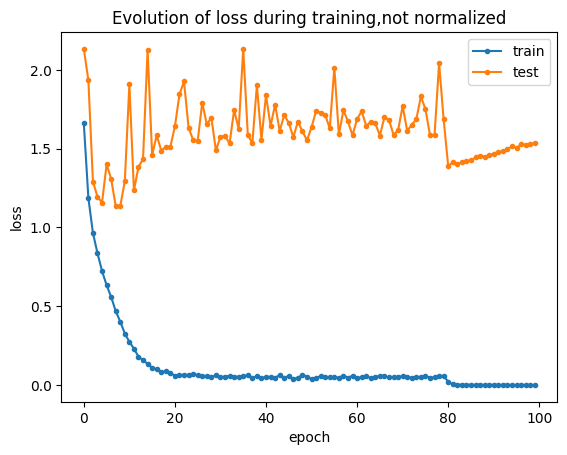

In [ ]:
run(num_epoch = num_epoch, is_renormalized=True)

In [ ]:
run(num_epoch = num_epoch, is_renormalized=False)